In [55]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
import importlib
import os
import json
from datetime import datetime
import inspect
import os
import sys
sys.path.append('../Classes')
from my_model_class import Model
from my_solving_class import Solving
import sgh_class
importlib.reload(sgh_class)
from scipy.integrate import solve_ivp
import colorsys
import matplotlib.colors as mcolors
from matplotlib import colors

# %matplotlib widget

In [56]:
red = ['#fda2b7', '#d10333', '#6c011a']
yellow = ['#fde69a', '#f9c105', '#c79b04']
blue = ['#3fb5fb', '#0384d0', '#02456c']

## calculate for canopy and then root mechanism

In [76]:
# canopy

size = 300
# beta_a = 1/3
# beta_e = 4
beta_a = 0.9
beta_e = 1.1

x = sgh_class.SGH_class(tree_root_active=0, shading_active=1, logistic_active=0, beta_a=beta_a, beta_e=beta_e)
p = np.linspace(0.01, 800/180, size)
c = np.linspace(0, 1, size)

N_p = len(p)
N_c = len(c)

B_results = np.full((N_p, N_c), np.nan)

run_code = False

if run_code:
    for i, precip in enumerate(p):
        for j, c_val in enumerate(c):
            print(f"p={precip*180:.1f} mm/yr, c={c_val:.2f}")
            B_results[i, j] = x.analytical_solutions_no_carrying_capacity(p=precip, c=c_val)[0] * 1000  # convert to g
    np.savetxt('B_results_k0_canopy.csv', B_results)
    np.savetxt('p_c_arrays_k0_canopy.csv', np.c_[p, c])

B_results_canopy = np.loadtxt('B_results_k0_canopy.csv')
p_c_arrays_canopy = np.loadtxt('p_c_arrays_k0_canopy.csv')
p_heatmap = p_c_arrays_canopy[:, 0]
c_heatmap = p_c_arrays_canopy[:, 1]

In [29]:
# root

size = 300

x = sgh_class.SGH_class(tree_root_active=1, shading_active=0, logistic_active=0)
p = np.linspace(0.01, 800/180, size)
c = np.linspace(0, 1, size)

N_p = len(p)
N_c = len(c)

B_results = np.full((N_p, N_c), np.nan)

run_code = False

if run_code:
    for i, precip in enumerate(p):
        for j, c_val in enumerate(c):
            print(f"p={precip*180:.1f} mm/yr, c={c_val:.2f}")
            B_results[i, j] = x.analytical_solutions_no_carrying_capacity(p=precip, c=c_val)[0] * 1000  # convert to g
    np.savetxt('B_results_k0_root.csv', B_results)
    np.savetxt('p_c_arrays_k0_root.csv', np.c_[p, c])

B_results_root = np.loadtxt('B_results_k0_root.csv')
p_c_arrays_root = np.loadtxt('p_c_arrays_k0_root.csv')
p_heatmap = p_c_arrays_root[:, 0]
c_heatmap = p_c_arrays_root[:, 1]

In [77]:
def viability(c, params):
    qs = params['ksat']
    m = params['d']
    a = params['a']
    gamma = params['gamma']
    beta_a = params['beta_a']
    # beta_e = params['beta_e']
    fa = (1-c)**(1/beta_a)
    return qs * (m / (a*fa))**gamma

## plot

/var/folders/hg/vb3h0zd17wn6zfm9q5zk3pbw0000gn/T/ipykernel_4071/4230483106.py:18: RuntimeWarning: invalid value encountered in log
  B_rel = np.log(B_results_canopy / b_no_trees[:, np.newaxis])
/var/folders/hg/vb3h0zd17wn6zfm9q5zk3pbw0000gn/T/ipykernel_4071/2374843195.py:9: RuntimeWarning: divide by zero encountered in divide
  return qs * (m / (a*fa))**gamma


<Figure size 640x480 with 0 Axes>

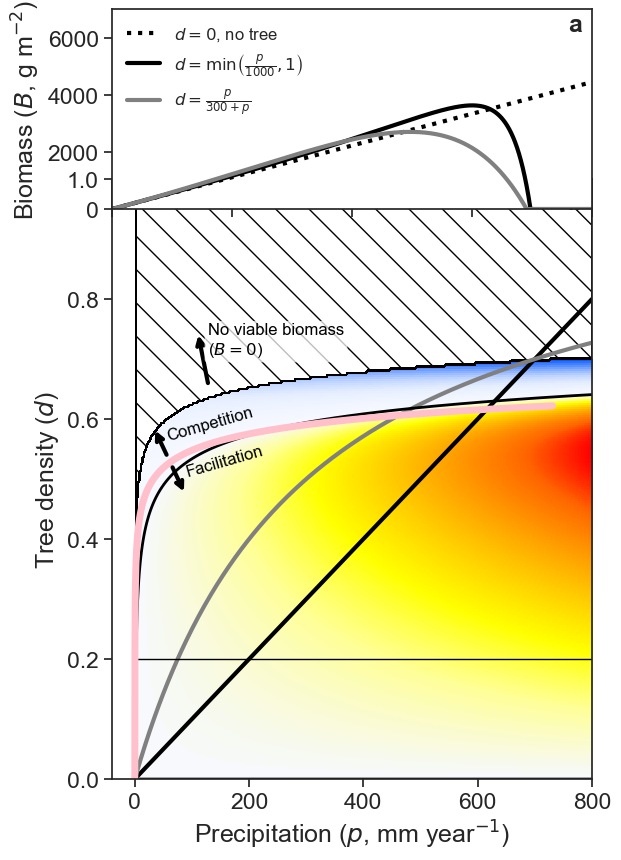

In [78]:
plt.clf()
fig = plt.figure(figsize=(8, 10),)
# fig.subplots_adjust(hspace=0.10, wspace=0.4, left=0.15, bottom=0.15, top=0.93, right=0.97)

# [left, bottom, width, height] — all in *figure-relative coordinates* (0–1)
ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.6])

# ax1 = fig.add_axes([0.2, 0.1, 0.6, 0.6])

####################
# Heatmap
####################


b_no_trees = B_results_canopy[:, 0]
B_collapse_mask = B_results_canopy < 1e-5  # mask where biomass is effectively zero
# B_abs = B_results - b_no_trees[:, np.newaxis]
B_rel = np.log(B_results_canopy / b_no_trees[:, np.newaxis])

B_abs = B_results_canopy - b_no_trees[:, np.newaxis]
B_abs[B_collapse_mask] = np.nan

B_black = np.zeros_like(B_abs)
B_black[~B_collapse_mask] = np.nan

p_peryear = p_heatmap * 180

from palettable.colorbrewer.diverging import RdGy_11
from palettable.cartocolors.diverging import Tropic_7
from palettable.lightbartlein.diverging import BlueOrangeRed_13_r
from palettable.lightbartlein.diverging import BlueOrangeRed_13
from palettable.scientific.diverging import Vik_19_r
div_cmap = BlueOrangeRed_13.mpl_colormap

vmin = float(np.nanmin(B_abs))
vmax = float(np.nanmax(B_abs))
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im = ax1.imshow(
    B_abs.T,
    cmap=div_cmap,
    norm=norm,
    # alpha=0.9,
    extent=[p_peryear.min(), p_peryear.max(), c_heatmap.min(), c_heatmap.max()],
    aspect='auto',
    origin='lower',
    interpolation='nearest'
)
# cbar = fig.colorbar(im, ax=ax)

# Overlay B_black with hatching for collapsed regions
# ax.imshow(
#     B_black.T,
#     cmap='gray',
#     extent=[180*p.min(), 180*p.max(), c.min(), c.max()],
#     aspect='auto',
#     origin='lower',
#     interpolation='nearest',
#     alpha=0,  # Make the overlay transparent
# )
# Add hatching using contour for collapsed regions
collapsed_mask = np.isnan(B_black.T)
h = ax1.contourf(
    p_peryear, c_heatmap, ~collapsed_mask,
    levels=[0.5, 1.5],
    colors='white',
    hatches=['\\'],
    extent=[p_peryear.min(), p_peryear.max(), c_heatmap.min(), c_heatmap.max()],
    origin='lower'
)
h.set_edgecolor('black')

c1 = p_peryear / 1000.0
c2 = p_peryear / (300 + p_peryear)

ax1.plot(p_peryear, c1, color='black', linestyle='-', linewidth=3)
ax1.plot(p_peryear, c2, color='gray', linestyle='-', linewidth=3)

exp_levels = [0]
# Make a mesh in plotting units for contour
PP, CC = np.meshgrid(p_peryear, c_heatmap)
CS = ax1.contour(PP, CC, B_abs.T, levels=exp_levels, colors='black', linestyles='-', linewidths=2)
# ax1.clabel(CS, levels=exp_levels, inline=True, fmt='%d', fontsize=12, colors='k')

# CS = ax1.contour(PP, CC, B_abs.T, levels=[-1000], colors='pink', linestyles='-', linewidths=2)

def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

forceAspect(ax1,aspect=1)

# ax1.plot(p_peryear, c_heatmap*0+0.1, color='black', lw=1)
ax1.plot(p_peryear, c_heatmap*0+0.2, color='black', lw=1)
# ax1.plot(p_peryear, c_heatmap*0+0.3, color='black', lw=1)


####################
# Line plots
####################

ax1_coords = ax1.get_position().bounds
# Add ax2 below ax1, with identical horizontal dimensions
# Place ax2 directly below ax1, matching its horizontal position and width, but with a shorter height
ax0 = fig.add_axes([ax1_coords[0], ax1_coords[1] + ax1_coords[3] + 0.03, ax1_coords[2], 0.20])

p_peryear = np.linspace(0, 800, 1000)
c1_theshold = 1000
c1 = p_peryear / c1_theshold
c1[c1>=1] = 0.99999
c2_threshold = 300
c2 = p_peryear / (c2_threshold + p_peryear)
p = p_peryear / 180
x = sgh_class.SGH_class(tree_root_active=0, shading_active=1, logistic_active=0, beta_a=beta_a, beta_e=beta_e)
bstar0,sstar0 = x.analytical_solutions_no_carrying_capacity(p=p, c=0, logistic_active=0)
ax0.plot(p_peryear, bstar0*1000, label=r'$d=0$, no tree', color='black', linestyle=':', lw=3)

bstar,sstar = x.analytical_solutions_no_carrying_capacity(p=p, c=c1, beta_a=beta_a, beta_e=beta_e, logistic_active=0)
bstar[bstar<0] = 0
ax0.plot(p_peryear, bstar*1000, label=rf'$d = \min\left(\frac{{p}}{{{c1_theshold:.0f}}},1\right)$', color='black', linestyle='-', lw=3)#, clip_on=False)

bstar,sstar = x.analytical_solutions_no_carrying_capacity(p=p, c=c2, beta_a=beta_a, beta_e=beta_e, logistic_active=0)
bstar[bstar<0] = 0
ax0.plot(p_peryear, bstar*1000, label=rf"$d = \frac{{p}}{{{c2_threshold:.0f} + p}}$", color='gray', linestyle='-', lw=3)#, clip_on=False)
ax1.set_xlabel(r'Precipitation ($\mathit{p}$, mm year$^{-1}$)')
ax0.set_ylabel(r'Biomass ($\mathit{B}$, g m$^{-2}$)')
ax0.set(xlim=(0,800),
          ylim=(0,7000),
          xticklabels=[])
ax0.legend(frameon=False, loc='upper left', fontsize=12)

# ax[1].plot(p*180, p*0, color='black', linestyle=':', lw=3, clip_on=False)
# ax[1].plot(p*180, c1, color=blue[0], linestyle='-', lw=3, clip_on=False)
# ax[1].plot(p*180, c2, color=blue[1], linestyle='-', lw=3, clip_on=False)
ax1.set_ylabel(r'Tree density ($\mathit{d}$)')

ax0.text(0.98, 0.98, 'a', transform=ax0.transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
ax1.text(0.98, 0.98, 'b', transform=ax1.transAxes, fontsize=18, fontweight='bold', va='top', ha='right')


######## Annotations ########

center = [0.12, 0.53]
diag_offset = 0.03
ax1.annotate(
        '', 
        xy=(center[0]+0.01*0, center[1]-0.01*0), 
        xytext=(center[0]+diag_offset, center[1]-1.7*diag_offset),
        xycoords='axes fraction',
        textcoords='axes fraction',
        size=12,
        clip_on=False,
        ha='left',
        va='top',
        arrowprops=dict(color='black', arrowstyle="<-", connectionstyle="arc3,rad=0.0", linewidth=3, shrinkA=0, shrinkB=5)
)

ax1.annotate(
        '', 
        xy=(center[0]-0.01*0, center[1]+0.01*0), 
        xytext=(center[0]-diag_offset, center[1]+1.7*diag_offset),
        xycoords='axes fraction',
        textcoords='axes fraction',
        size=12,
        clip_on=False,
        ha='left',
        va='top',
        arrowprops=dict(color='black', arrowstyle="<-", connectionstyle="arc3,rad=0.0", linewidth=3, shrinkA=0, shrinkB=5)
)
ax1.text(0.11, 0.56, 'Competition', fontsize=12, color="black", ha='left', va='bottom', transform=ax1.transAxes, rotation=16)
ax1.text(0.15, 0.50, 'Facilitation', fontsize=12, color="black", ha='left', va='bottom', transform=ax1.transAxes, rotation=16)

ax1.annotate(
        '', 
        xy=(0.2, 0.66), 
        xytext=(0.18, 0.74),
        xycoords='axes fraction',
        textcoords='axes fraction',
        size=12,
        # clip_on=False,
        ha='left',
        va='top',
        arrowprops=dict(color='black', arrowstyle="<-", connectionstyle="arc3,rad=0.0", linewidth=3, shrinkA=0, shrinkB=0)
)
ax1.text(
    0.20, 0.70, 'No viable biomass\n'+r'($B=0$)', 
    fontsize=12, color="black", ha='left', va='bottom', 
    transform=ax1.transAxes, rotation=0,
    bbox=dict(facecolor='white', alpha=0.75, edgecolor='none', boxstyle='round,pad=0.2')
)

p_viable = viability(c_heatmap, x.params)*180
to_plot_mask = np.where(p_viable < 800)
ax1.plot(p_viable[to_plot_mask], c_heatmap[to_plot_mask], color='pink', lw=5)

ax1.set_aspect('equal')
ax1.set_aspect('auto')


# fig.savefig('tree_cover_mechanism_II.png', dpi=300, bbox_inches='tight')
# fig.savefig('tree_cover_mechanism_II.pdf', bbox_inches='tight')

/var/folders/hg/vb3h0zd17wn6zfm9q5zk3pbw0000gn/T/ipykernel_4071/2374843195.py:9: RuntimeWarning: divide by zero encountered in divide
  return qs * (m / (a*fa))**gamma


[(0.0, 800.0),
 (0.0, 1.0),
 Text(0.5, 0, 'Precipitation ($\\mathit{p}$, mm year$^{-1}$)'),
 Text(0, 0.5, 'Tree density ($\\mathit{d}$)')]

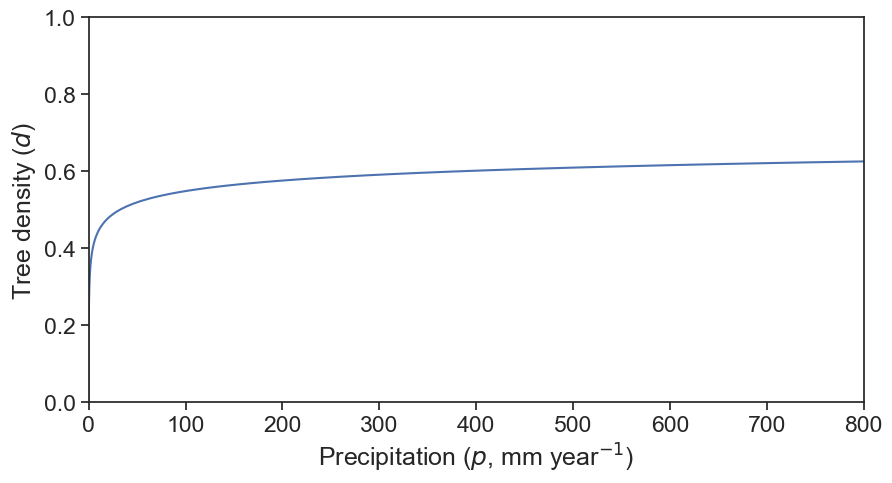

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharey=True)
ax.plot(viability(c_heatmap, x.params)*180, c_heatmap)
ax.set(xlim=(0,800), ylim=(0,1), xlabel=r'Precipitation ($\mathit{p}$, mm year$^{-1}$)', ylabel=r'Tree density ($\mathit{d}$)')

Text(0.98, 0.98, 'b')

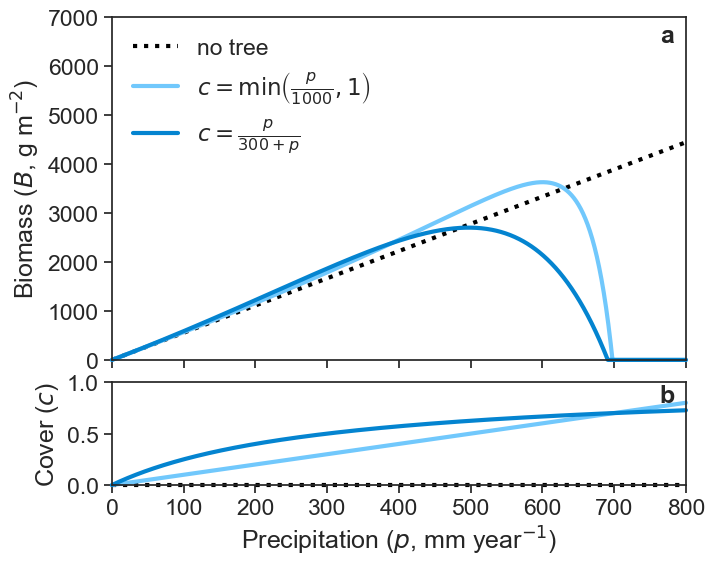

In [4]:
fig, ax = plt.subplots(2,1, figsize=(7, 6), height_ratios=[1,0.3], sharex=True)
fig.subplots_adjust(hspace=0.10, wspace=0.4, left=0.15, bottom=0.15, top=0.93, right=0.97)


p = np.linspace(0, 800, 1000)
c1_theshold = 1000
c1 = p / c1_theshold
c1[c1>=1] = 0.99999
c2_threshold = 300
c2 = p / (c2_threshold + p)
p = p / 180
bstar0,sstar0 = x.analytical_solutions_no_carrying_capacity(p=p, c=0, logistic_active=0)
ax[0].plot(p*180, bstar0*1000, label='no tree', color='black', linestyle=':', lw=3)

bstar,sstar = x.analytical_solutions_no_carrying_capacity(p=p, c=c1, beta_a=beta_a, beta_e=beta_e, logistic_active=0)
bstar[bstar<0] = 0
ax[0].plot(p*180, bstar*1000, label=rf'$c = \min\left(\frac{{p}}{{{c1_theshold:.0f}}},1\right)$', color=blue[0], linestyle='-', lw=3, clip_on=False)

bstar,sstar = x.analytical_solutions_no_carrying_capacity(p=p, c=c2, beta_a=beta_a, beta_e=beta_e, logistic_active=0)
bstar[bstar<0] = 0
ax[0].plot(p*180, bstar*1000, label=rf"$c = \frac{{p}}{{{c2_threshold:.0f} + p}}$", color=blue[1], linestyle='-', lw=3, clip_on=False)

ax[1].set_xlabel(r'Precipitation ($\mathit{p}$, mm year$^{-1}$)')
ax[0].set_ylabel(r'Biomass ($\mathit{B}$, g m$^{-2}$)')
ax[0].set(xlim=(0,800),
          ylim=(0,7000))
ax[0].legend(frameon=False, loc='upper left')

ax[1].plot(p*180, p*0, color='black', linestyle=':', lw=3, clip_on=False)
ax[1].plot(p*180, c1, color=blue[0], linestyle='-', lw=3, clip_on=False)
ax[1].plot(p*180, c2, color=blue[1], linestyle='-', lw=3, clip_on=False)
ax[1].set_ylabel(r'Cover ($\mathit{c}$)')

ax[1].set(ylim=(0,1))

ax[0].text(0.98, 0.98, 'a', transform=ax[0].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')
ax[1].text(0.98, 0.98, 'b', transform=ax[1].transAxes, fontsize=18, fontweight='bold', va='top', ha='right')

# fig.savefig('tree_cover_mechanism.png', dpi=300)
# fig.savefig('tree_cover_mechanism.pdf')